# Crowdfunding Prediction

### Import packages

In [5]:
import pandas
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as pyplot
from sklearn.metrics import silhouette_score

In [2]:
standardizer = StandardScaler()

### Import data

In [3]:
kickstarter_df = pandas.read_excel("Kickstarter.xlsx")

## Task: Preprocess 

There are 45 variables in the dataset, but not every of them plays a vital role in this
prediction model. Thus, to make the machine learning feature selection algorithm more efficient, 
I choose to extract important factors intuitively first.

To begin, I choose to use the state variable as the target variable by only keeping the 
‘successful’ and ‘failed’ status of projects and then dummifying them. The goal and
disable_communication are both important, so I select them. There are also some correlated 
predictors such as country/currency static_usd_rate and name/name_len_clean and blurb_len /
blurb_len_clean, to avoid the correlation problem in the prediction model, I only include one 
predictor in each similar pair. But rather than directly adding goal and static_usd_rate to the 
model, I notice that the units of values in goal column are not unified, thus I create a new 
variable by multiplying goal with static_usd_rate to unify the currency. Moreover, most of the 
text predictors in the dataset do not tend to have a direct impact on the target variable, thus I drop 
all those variables such as name/category/day/year; but the day range does play an important role 
in raising funds, so I pick the create_to_launch_days and launch_to_deadline_days.

More importantly, the model aims to predict by the time the project launches, so I drop the predictors 
such as backers_count/staff_pick/pledged/usd_pledged/launch_to_state_change_days. The 
spotlight is perfectly correlated with the target variable, and I also drop it before constructing the 
model. As such, this model ends up with 6 predictors and 1 target variable
in total.

In [4]:
#only include observations where the variable “state” takes the value “successful” or “failure” 
kickstarter = kickstarter_df[(kickstarter_df['state'] == 'successful') | (kickstarter_df['state'] == 'failed')]
#reassign values to variables before converting to dummies
kickstarter['disable_communication'] = np.where(kickstarter['disable_communication'] == True, 'No_communication', 'With_communication')

# For analysis - we need to change these variables as dummy variables
dummy_state=pandas.get_dummies(kickstarter.state)
dummy_disable_communication=pandas.get_dummies(kickstarter.disable_communication)
# genearte final data for analysis including dummy variables
kickstarter = kickstarter.join(dummy_state)
kickstarter = kickstarter.join(dummy_disable_communication)

#assign new column as goal*static_usd_rate
kickstarter['goal_usd'] = kickstarter['static_usd_rate']*kickstarter['goal']

#new dataframe with used variables
kickstarter_used = kickstarter[["successful", 'goal_usd',  'With_communication',
                              'name_len', 'blurb_len', 'launch_to_deadline_days', 'create_to_launch_days']]
kickstarter_used = kickstarter_used.dropna()

/var/folders/f5/7w8rh9rx11938lxyvdr2g_940000gn/T/ipykernel_45645/947429085.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kickstarter['disable_communication'] = np.where(kickstarter['disable_communication'] == True, 'No_communication', 'With_communication')


## Task: classification model

In [6]:
y = kickstarter_used['successful']
X = kickstarter_used.drop(columns=['successful'])

### Feature Selection with Random Forest

In [7]:
randomforest = RandomForestClassifier(random_state=5, oob_score=True)
model1 = randomforest.fit(X, y)

### To find the important features

In [8]:
coe = list()
for i in range(len(model1.feature_importances_)):
    a = model1.feature_importances_[i]
    coe.append(a)  
li = []
for i in range(len(coe)):
    if coe[i] > 0:
        li.append(i)


### To get the three most important predictors

In [9]:
import heapq
col = heapq.nlargest(3, range(len(coe)), key=coe.__getitem__)
X.columns[col]
rf_X = X[X.columns[col]]
#standardize
rf_X_std = standardizer.fit_transform(rf_X)

In this prediction model, the three most important predictors are
goal_usd, create_to_launch_days and blurb_len. Therefore, I construct the classification and 
clustering model with these three crucial variables.

### Gradient Boosting

In [10]:
###run Gradient Boosting
X_train, X_test, y_train, y_test = train_test_split(rf_X , y, test_size = 0.3, random_state = 8)
from sklearn.ensemble import GradientBoostingClassifier
gbt = GradientBoostingClassifier()
model1b = gbt.fit(X_train, y_train)
y_test_pred = model1b.predict(X_test)
metrics.accuracy_score(y_test, y_test_pred)

0.6927326816829579

To begin, I use the three predictors selected by Random Forest Algorithm and the target 
variable “successful” to construct a gradient boosting model. In this model, I randomly split the 
dataset into 30% for testing and 70% for training, to measure the performance of the prediction. 
And since the accuracy score of the constructed prediction model is above 69%, it is reasonable 
to use this classification model to predict the probability of getting enough funding.

## Algorithms attempted to generate the highest accuracy

#### Run K-NN
X_train, X_test, y_train, y_test = train_test_split(rf_X_std, y, test_size = 0.3, random_state = 5)

knn = KNeighborsClassifier(n_neighbors=5) 

model1b = knn.fit(X_train,y_train)

y_test_pred = model1b.predict(X_test)

metrics.accuracy_score(y_test, y_test_pred)

from sklearn.metrics import mean_squared_error 

mse = mean_squared_error(y_test, y_test_pred)

print(mse)


#### Run random forest
X_train, X_test, y_train, y_test = train_test_split(rf_X , y, test_size = 0.3, random_state = 5)

model1b = randomforest.fit(X_train,y_train)

y_test_pred = model1b.predict(X_test)

metrics.accuracy_score(y_test, y_test_pred)


#### Run ANN
X_train, X_test, y_train, y_test = train_test_split(rf_X_std, y, test_size = 0.3, random_state = 5)

from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(11),max_iter=1000,random_state=5)

model1b = mlp.fit(X_train,y_train)

y_test_pred = model1b.predict(X_test)

## Task: clustering model

### K-Means
Using the predictors selected by random forest

In [11]:
df2 = X[X.columns[col]]

#standardize
df2_std = standardizer.fit_transform(df2)

### Check the relationship between number of clusters and within-cluster variance

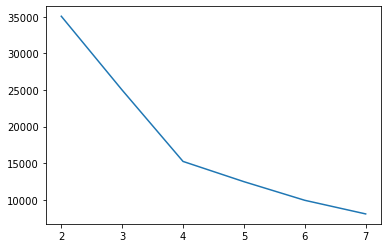

In [12]:
withinss = []
for i in range (2,8):
    kmeans = KMeans(n_clusters=i, random_state = 8)
    model = kmeans.fit(df2_std)
    withinss.append(model.inertia_)
pyplot.plot([2,3,4,5,6,7],withinss)

### Check the best silhouette_score

In [13]:
for i in range (2,5):    
    kmeans = KMeans(n_clusters=i, random_state = 8)
    model2 = kmeans.fit(df2_std)
    labels = model2.labels_
    print(i,':',np.average(silhouette_score(df2_std,labels)))

2 : 0.9687056013840496
3 : 0.6923259726863932
4 : 0.4975667978335678


#### Methodology overview: 
I firstly apply the Elbow method to check the relationship between number of clusters 
and within-cluster variance. According to the Elbow, the two values are negatively correlated, 
and the balance between the two becomes reasonable when it is at 3 or 4 clusters. Thus, I further apply the Silhouette score method to find the optimal K value. Since the silhouette value 
measures the cohesion within the same cluster and separation among different clusters, I decide 
to set the number of clusters as 3 (with score equals to 0.69), where the silhouette value is higher
than the value with k at 4 (with score equals to 0.498).
 As such, I get 3 clusters where the object 
is well matched within cluster but poorly matched to neighboring clusters.

### Choosing n_clusters=3 which created the relatively great silhouette_score

In [14]:
kmeans = KMeans(n_clusters=3, random_state = 8)
model2 = kmeans.fit(df2_std)
labels = model2.labels_
silhouette = silhouette_samples(df2_std,labels)
silhouette_score(df2_std,labels)

0.6923259726863932

### Fitting KMeans for 3 Clusters and find centers of clusters

In [15]:
Km = KMeans(init = 'k-means++', n_clusters =3, n_init = 100, random_state = 8).fit(df2_std)
labels = pandas.DataFrame(Km.labels_)
clustered_data = df2.assign(Cluster = labels)
clustered_data.groupby(['Cluster']).mean()

,goal_usd,create_to_launch_days,blurb_len
Cluster,,,
0.0,82578.881176,48.590752,19.050008
1.0,43920.912272,118.000000,21.000000
2.0,57545.050905,50.774319,18.538911


### Clustering analysis

Cluster 0: projects with medium level of goal, medium number of days between creation 
and launch and small length of blurb. 

Cluster 1: projects with high level of goal, small number of 
days between creation and launch and medium length of blurb. 

Cluster 2: projects with low level 
of goal, large number of days between creation and launch and large length of blurb.

## Managerial Implication

Accurately predicting the probability of getting enough funds is challenging, but based on 
the analysis above, the goal of funds in USD, length of blurb and days between creation and 
launch are three essentials that can both help project owners to understand what to improve and
can help crowdfunding platform operators to better arrange the position of projects on the 
website to avoid social resources wasting. This project gives professionals in the crowdfunding 
platforms and project owners more insights into the characteristics that influence the chance of 
success in funding.